Got it! Since you’re working on **skin disease classification**, here’s the practical roadmap you should follow, **from simplest to most effective**:

---

## **1️⃣ Start Simple — Custom CNN**
- **Why:** Helps you understand the data, preprocessing, and training workflow.  
- **Architecture:** 3–5 convolutional layers, pooling, 1–2 fully connected layers.  
- **Pros:**  
  - Lightweight, quick to train  
  - Understand overfitting/underfitting  
- **Cons:**  
  - Likely low accuracy on complex images  
- **Use for:** Learning, debugging preprocessing, augmentation, batch size, optimizer settings.

---

## **2️⃣ Transfer Learning with Pretrained CNNs**
- **Why:** Skin datasets are usually small → pretrained networks **generalize better**.  
- **Recommended Models:**  
  - **ResNet-18 or ResNet-34** → lightweight, fast to train  
  - **DenseNet-121** → often used in medical imaging, handles small datasets well  
  - **EfficientNet-B0/B1** → high accuracy with fewer parameters  

- **Steps:**  
  1. Load pretrained model on **ImageNet**  
  2. Replace final layer to match **number of disease classes**  
  3. Freeze early layers, fine-tune last layers first  
  4. Later, unfreeze more layers if needed  

- **Pros:**  
  - Handles small/imbalanced datasets well  
  - Better feature extraction  
- **Cons:**  
  - Slightly heavier than simple CNN  

---

## **3️⃣ Data Augmentation**
- Must be done **carefully** for medical images:  
  - **Train/Minority Transform:**  
    - Resize (128×128 or 224×224)  
    - Horizontal/vertical flip  
    - Rotation (±15°)  
    - Random brightness/contrast  
    - Minor grid distortion or elastic transform  
  - **Test Transform:**  
    - Only Resize and Normalize  

---

## **4️⃣ Handle Class Imbalance**
- **Options:**  
  1. Oversample minority classes  
  2. Weighted loss function (`CrossEntropyLoss(weight=class_weights)` in PyTorch)  
  3. Synthetic data using **GANs** (optional, advanced)  

---

## **5️⃣ Evaluation Metrics**
- **Not just accuracy** for imbalanced datasets  
- Use:  
  - **F1-score** per class  
  - **Confusion matrix**  
  - **ROC-AUC per class**  

---

## **6️⃣ Advanced — Vision Transformers**
- If dataset is large (thousands of images per class) or you want **state-of-the-art**, try:  
  - **ViT (Vision Transformer)**  
  - **Swin Transformer**  
- Requires:  
  - More GPU memory  
  - Careful hyperparameter tuning  

---

### ✅ **Recommended Path for You**
1. **Custom CNN** → small subset → understand preprocessing & augmentation  
2. **Pretrained CNN (ResNet/DenseNet/EfficientNet)** → use transfer learning + weighted loss  
3. **Optional:** ViT or hybrid CNN+Transformer if dataset grows  

---

If you want, I can **write a ready-to-use PyTorch pipeline** specifically for **imbalanced skin disease dataset**, with:  
- Proper transforms  
- Weighted loss  
- Transfer learning on **ResNet/DenseNet**  
- Training & evaluation code  

Do you want me to do that next?

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from IPython.display import display

import kornia.augmentation as K
from kornia.geometry.transform import Resize
from kornia.constants import Resample
from PIL import Image
import cv2
import torchvision.transforms.functional as TF
from tqdm import tqdm
import tqdm as notebook_tqdm
tqdm.pandas()

In [6]:
import os
import sys

# Add root path to sys.path so imports work
sys.path.append(os.path.abspath(os.path.join('..')))


In [ ]:
pip install ipywidgets

pip install --upgrade jupyter ipywidgets


In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("subirbiswas19/skin-disease-dataset")

print("Path to dataset files:", path)

100%|██████████| 17.3M/17.3M [00:08<00:00, 2.19MB/s]

Extracting files...


Path to dataset files: /home/mcqueen/.cache/kagglehub/datasets/subirbiswas19/skin-disease-dataset/versions/1


In [8]:
for root, dirs, files in os.walk(path):
    print("Folder:", root)


Folder: /home/mcqueen/.cache/kagglehub/datasets/subirbiswas19/skin-disease-dataset/versions/1
Folder: /home/mcqueen/.cache/kagglehub/datasets/subirbiswas19/skin-disease-dataset/versions/1/skin-disease-datasaet
Folder: /home/mcqueen/.cache/kagglehub/datasets/subirbiswas19/skin-disease-dataset/versions/1/skin-disease-datasaet/test_set
Folder: /home/mcqueen/.cache/kagglehub/datasets/subirbiswas19/skin-disease-dataset/versions/1/skin-disease-datasaet/test_set/BA- cellulitis
Folder: /home/mcqueen/.cache/kagglehub/datasets/subirbiswas19/skin-disease-dataset/versions/1/skin-disease-datasaet/test_set/FU-ringworm
Folder: /home/mcqueen/.cache/kagglehub/datasets/subirbiswas19/skin-disease-dataset/versions/1/skin-disease-datasaet/test_set/FU-nail-fungus
Folder: /home/mcqueen/.cache/kagglehub/datasets/subirbiswas19/skin-disease-dataset/versions/1/skin-disease-datasaet/test_set/FU-athlete-foot
Folder: /home/mcqueen/.cache/kagglehub/datasets/subirbiswas19/skin-disease-dataset/versions/1/skin-disease-

In [9]:
train_data_path = os.path.join(path,"skin-disease-datasaet","train_set")
test_data_path = os.path.join(path,"skin-disease-datasaet","test_set")

In [10]:
train_list_dir = os.listdir(train_data_path)
test_list_dir = os.listdir(test_data_path)

In [7]:
train_list_dir

['BA- cellulitis',
 'FU-ringworm',
 'FU-nail-fungus',
 'FU-athlete-foot',
 'VI-shingles',
 'BA-impetigo',
 'VI-chickenpox',
 'PA-cutaneous-larva-migrans']

In [8]:
label_mapping = {
    'VI-chickenpox': 0,
    'BA-impetigo': 1,
    'PA-cutaneous-larva-migrans': 2,
    'FU-nail-fungus': 3,
    'BA- cellulitis': 4,
    'VI-shingles': 5,
    'FU-ringworm': 6,
    'FU-athlete-foot': 7
}


In [9]:
data_train = []

for disease_name in train_list_dir:
    disease_folder_path = os.path.join(train_data_path, disease_name)
    train_disease_pic_names = os.listdir(disease_folder_path)

    for pic_name in train_disease_pic_names:
        pic_path = os.path.join(disease_folder_path, pic_name)
        data_train.append({"image_path": pic_path, "label": disease_name})


df_train = pd.DataFrame(data_train)
df_train["label_values"] = df_train["label"].map(label_mapping)


In [10]:
df_train

,image_path,label,label_values
0,/home/mcqueen/.cache/kagglehub/datasets/subirb...,BA- cellulitis,4
1,/home/mcqueen/.cache/kagglehub/datasets/subirb...,BA- cellulitis,4
2,/home/mcqueen/.cache/kagglehub/datasets/subirb...,BA- cellulitis,4
3,/home/mcqueen/.cache/kagglehub/datasets/subirb...,BA- cellulitis,4
4,/home/mcqueen/.cache/kagglehub/datasets/subirb...,BA- cellulitis,4
...,...,...,...
920,/home/mcqueen/.cache/kagglehub/datasets/subirb...,PA-cutaneous-larva-migrans,2
921,/home/mcqueen/.cache/kagglehub/datasets/subirb...,PA-cutaneous-larva-migrans,2
922,/home/mcqueen/.cache/kagglehub/datasets/subirb...,PA-cutaneous-larva-migrans,2
923,/home/mcqueen/.cache/kagglehub/datasets/subirb...,PA-cutaneous-larva-migrans,2


In [11]:
data_test = []

for disease_name in test_list_dir:
    disease_folder_path = os.path.join(test_data_path, disease_name)
    test_disease_pic_names = os.listdir(disease_folder_path)

    for pic_name in test_disease_pic_names:
        pic_path = os.path.join(disease_folder_path, pic_name)
        data_test.append({"image_path": pic_path, "label": disease_name})

df_test = pd.DataFrame(data_test)
df_test["label_values"] = df_test["label"].map(label_mapping)

In [12]:
df_test

,image_path,label,label_values
0,/home/mcqueen/.cache/kagglehub/datasets/subirb...,BA- cellulitis,4
1,/home/mcqueen/.cache/kagglehub/datasets/subirb...,BA- cellulitis,4
2,/home/mcqueen/.cache/kagglehub/datasets/subirb...,BA- cellulitis,4
3,/home/mcqueen/.cache/kagglehub/datasets/subirb...,BA- cellulitis,4
4,/home/mcqueen/.cache/kagglehub/datasets/subirb...,BA- cellulitis,4
...,...,...,...
229,/home/mcqueen/.cache/kagglehub/datasets/subirb...,PA-cutaneous-larva-migrans,2
230,/home/mcqueen/.cache/kagglehub/datasets/subirb...,PA-cutaneous-larva-migrans,2
231,/home/mcqueen/.cache/kagglehub/datasets/subirb...,PA-cutaneous-larva-migrans,2
232,/home/mcqueen/.cache/kagglehub/datasets/subirb...,PA-cutaneous-larva-migrans,2


                      Disease  count
0              BA- cellulitis    136
1               VI-chickenpox    136
2                 VI-shingles    130
3              FU-nail-fungus    129
4             FU-athlete-foot    124
5  PA-cutaneous-larva-migrans    100
6                 FU-ringworm     90
7                 BA-impetigo     80


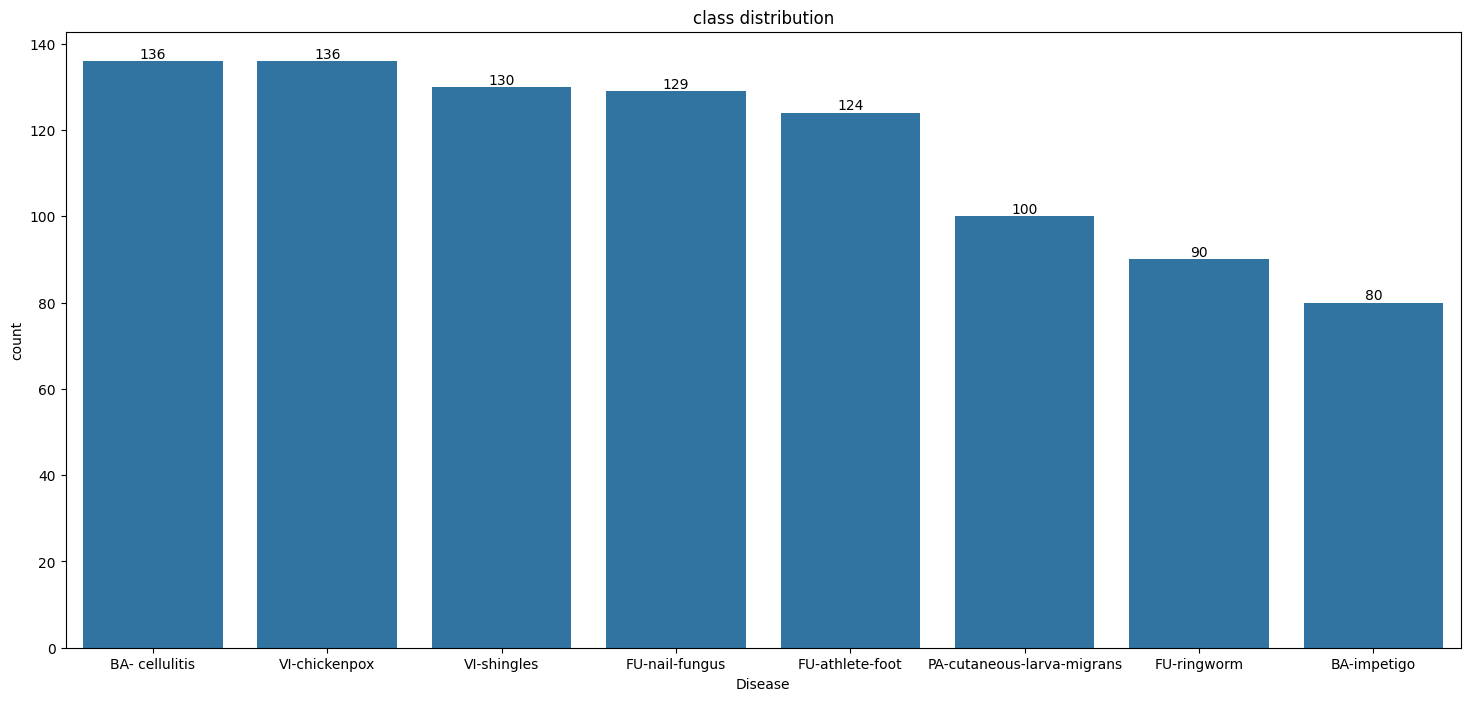

In [13]:
label_counts =  df_train["label"].value_counts().reset_index()
label_counts.columns = ["Disease", "count"]
print(label_counts)
plt.figure(figsize=(18,8))
ax = sns.barplot(x=  "Disease", y = "count", data = label_counts)
plt.title("class distribution")
ax.bar_label(ax.containers[0])
plt.show()


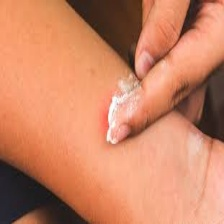

In [14]:
from PIL import Image

image = Image.open(df_train["image_path"].iloc[0])
image_array = np.array(image)

display(image)

In [15]:
import cv2

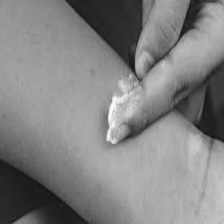

In [16]:
gray = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
display(Image.fromarray(gray))


In [17]:
import numpy as np

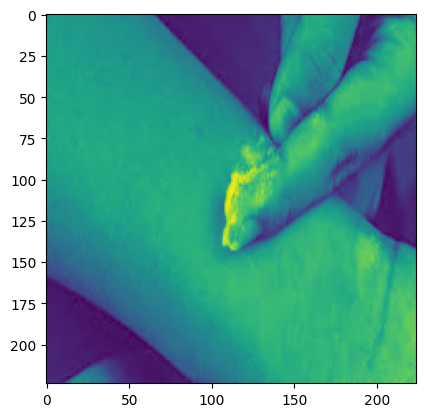

In [18]:
norm_image = (gray - np.min(gray)) / (np.max(gray) - np.min(gray))
plt.imshow(norm_image)

In [21]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ---------------------------
# 1️⃣ Training Transform
# ---------------------------
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=20, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15,  p=0.3),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=0.3),
    A.Resize(128, 128),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

# ---------------------------
# 2️⃣ Minority Class Transform (stronger augmentations)
# ---------------------------
minority_transform = A.Compose([
    A.HorizontalFlip(p=0.7),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.7),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=20, p=0.7),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
    A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=20,  p=0.5),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=0.4),
    A.GaussNoise( p=0.3),
    A.Resize(128, 128),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

# ---------------------------
# 3️⃣ Test / Validation Transform
# ---------------------------
test_transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])


In [ ]:
from torchvision import transforms

# Basic transforms for training
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(p=0.5),       # light augmentation
    transforms.RandomRotation(15),                # rotate ±15°
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),                        # converts HxWxC [0,255] -> [0,1]
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# For minority classes: add stronger augmentation
minority_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# For test/validation: only resize + normalize
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])


In [40]:
label_counts

,Disease,count
0,BA- cellulitis,136
1,VI-chickenpox,136
2,VI-shingles,130
3,FU-nail-fungus,129
4,FU-athlete-foot,124
5,PA-cutaneous-larva-migrans,100
6,FU-ringworm,90
7,BA-impetigo,80


In [22]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [23]:
train_dataset = ImageFolder(root=train_data_path, transform=train_transform)
test_dataset = ImageFolder(root=test_data_path, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [24]:
from torch.utils.data import Dataset
import cv2

class AlbumentationsWrapper(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label_values']

        # Read and convert to RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Apply Albumentations
        if self.transform:
            img = self.transform(image=img)['image']  # ⚠️ pass as keyword

        return img, label


In [25]:
train_dataset = AlbumentationsWrapper(df_train, transform=train_transform)
test_dataset = AlbumentationsWrapper(df_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
from torch.utils.data import WeightedRandomSampler
import numpy as np

# Calculate weights for each sample
targets = [sample[1] for sample in train_dataset]
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in targets]

sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)

# Use sampler in DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
lgbm = LGBMClassifier(n_estimators=50, max_depth=5, force_col_wise=True)

lgbm.fit(x_train, y_train)
preds = lgbm.predict(x_test)
print(classification_report(y_test, preds))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
rfc_pred = rfc.predict(x_test)
print(classification_report(y_test, rfc_pred))
print(confusion_matrix(y_test, rfc_pred))

In [26]:
import torchvision

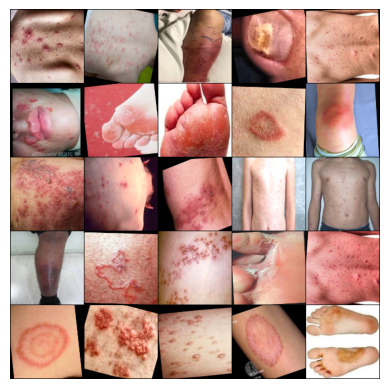

In [27]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:25], normalize=True, padding=1, nrow=5).numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

Simple CNN

In [28]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(),
            torch.nn.Linear(64 * 16 * 16, 512),  # updated for 128x128 input
            torch.nn.ReLU(),
            torch.nn.Linear(512, 8)  # number of classes
        )


    def forward(self, x):
        return self.model(x)

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = CNN().to(device)

num_epochs = 200
learning_rate = 0.001
weight_decay = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay)

cuda


In [38]:
train_loss_list = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:', end=' ')
    train_loss = 0
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss_list.append(train_loss / len(train_loader))
    print(f"Training loss = {train_loss_list[-1]}")

Epoch 1/200: Training loss = 2.034927244844108
Epoch 2/200: Training loss = 1.9648938754509235
Epoch 3/200: Training loss = 1.9172071876197025
Epoch 4/200: Training loss = 1.8327297218914689
Epoch 5/200: Training loss = 1.836430578396238
Epoch 6/200: Training loss = 1.7931804287022557
Epoch 7/200: Training loss = 1.756404658843731
Epoch 8/200: Training loss = 1.73797463137528
Epoch 9/200: Training loss = 1.6723599392792274
Epoch 10/200: Training loss = 1.6659045137208084
Epoch 11/200: Training loss = 1.613445491626345
Epoch 12/200: Training loss = 1.5541906397918175
Epoch 13/200: Training loss = 1.5324588150813663
Epoch 14/200: Training loss = 1.4638072951086636
Epoch 15/200: Training loss = 1.4857415495247677
Epoch 16/200: Training loss = 1.4503719518924583
Epoch 17/200: Training loss = 1.4575437718424304
Epoch 18/200: Training loss = 1.3880800830906834
Epoch 19/200: Training loss = 1.3942484403478688
Epoch 20/200: Training loss = 1.3813359614076286
Epoch 21/200: Training loss = 1.331

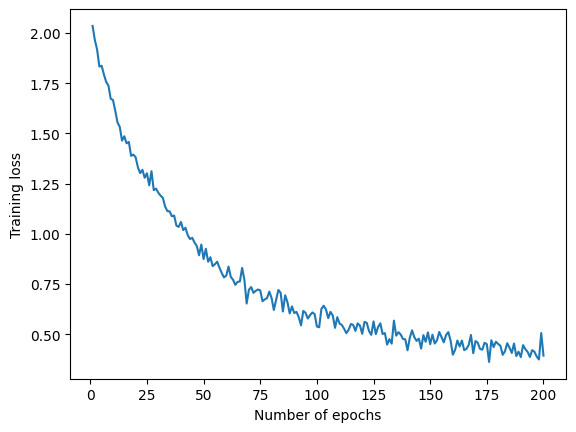

In [39]:
plt.plot(range(1, num_epochs + 1), train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.show()

In [40]:
test_acc = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        y_true = labels.to(device)
        outputs = model(images)
        _, y_pred = torch.max(outputs.data, 1)
        test_acc += (y_pred == y_true).sum().item()

print(f"Test set accuracy = {100 * test_acc / len(test_dataset)} %")

Test set accuracy = 81.62393162393163 %


In [ ]:
Test set accuracy = 76.4957264957265 %

In [50]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

model = model.to("cuda")


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler
import os

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [44]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [48]:
train_dataset = ImageFolder(root=train_data_path, transform=train_transform)
test_dataset = ImageFolder(root=test_data_path, transform=test_transform)

# Handle class imbalance
targets = [label for _, label in train_dataset]
class_counts = torch.bincount(torch.tensor(targets))
class_weights = 1. / class_counts.float()
sample_weights = [class_weights[label] for label in targets]

sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)

train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [51]:
model = models.densenet121(weights="IMAGENET1K_V1")
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 8)  # 8 output classes
model = model.to(device)

In [52]:
weights = torch.tensor([class_weights[i] for i in range(len(class_counts))]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [53]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 1.6401
Epoch [2/10], Loss: 1.0407
Epoch [3/10], Loss: 0.7957
Epoch [4/10], Loss: 0.6291
Epoch [5/10], Loss: 0.5932
Epoch [6/10], Loss: 0.5065
Epoch [7/10], Loss: 0.4847
Epoch [8/10], Loss: 0.4536
Epoch [9/10], Loss: 0.4338
Epoch [10/10], Loss: 0.4077


In [41]:
import torch
torch.cuda.empty_cache()


In [54]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"✅ Test Accuracy: {100 * correct / total:.2f}%")

✅ Test Accuracy: 94.02%


In [55]:
torch.save(model.state_dict(), "trained_densenet.pth")
print("✅ Model weights saved successfully!")


✅ Model weights saved successfully!


In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
# Load pretrained DenseNet and modify the final layer
model = models.densenet121(pretrained=False)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 8)  # 6 = your number of classes

# Load your trained weights
model.load_state_dict(torch.load("trained_densenet.pth", map_location="cpu"))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
def predict_image(image_path, model, transform, class_names):
    image = Image.open(image_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        outputs = model(img_tensor)
        _, preds = torch.max(outputs, 1)

    predicted_class = class_names[preds.item()]
    print(f"Prediction: {predicted_class}")
    return predicted_class
class_names =['BA- cellulitis', 'BA-impetigo', 'FU-athlete-foot', 'FU-nail-fungus', 'FU-ringworm', 'PA-cutaneous-larva-migrans', 'VI-chickenpox', 'VI-shingles']


image_path = "image/download.jpeg"
predict_image(image_path, model, transform, class_names)



Prediction: BA- cellulitis


'BA- cellulitis'